In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ajaypyatha","key":"47118be17f03eb8a083ea612f6a31172"}'}

In [2]:
#Downloading the CelebA dataset from the kaggle
!pip install -q kaggle
!chmod 600 /content/kaggle.json
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:32<00:00, 43.1MB/s]
100% 1.33G/1.33G [00:32<00:00, 44.4MB/s]


In [3]:
import shutil
shutil.unpack_archive("/content/celeba-dataset.zip")

In [4]:
##utils-> callbacks
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os

#### CALLBACKS
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_train_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)

In [53]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import numpy as np
import json
import pickle
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon


class VAEModel(Model):
    def __init__(self, encoder, decoder, r_loss_factor, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.built = True
        self.encoder = encoder
        self.decoder = decoder
        self.r_loss_factor = r_loss_factor

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.square(data - reconstruction), axis = [1,2,3]
            )
            reconstruction_loss *= self.r_loss_factor
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss, axis = 1)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self,inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)





class VariationalAutoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , r_loss_factor
        , use_batch_norm = False
        , use_dropout= False
        ):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.r_loss_factor = r_loss_factor

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        
        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        self.z = Sampling(name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, [self.mu, self.log_var, self.z], name = 'encoder')
        
        

        ### THE DECODER

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

            

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output, name = 'decoder')

        ### THE FULL VAE

        self.model = VAEModel(self.encoder, self.decoder, self.r_loss_factor)



    def compile(self, learning_rate):
        self.learning_rate = learning_rate
        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer)


    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)


    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
        
        checkpoint_filepath=os.path.join(run_folder, "weights/weights.h5")
        checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
        )



    def train_with_generator(self, data_flow, epochs, steps_per_epoch, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1, ):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint_filepath=os.path.join(run_folder, "weights/weights.h5")
        checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

        self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))


        self.model.fit(
            data_flow
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
            , steps_per_epoch=steps_per_epoch 
            )




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)

In [6]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

os.makedirs(RUN_FOLDER,exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'viz'),exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'images'),exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'weights'),exist_ok=True)

mode =  'build' #'load' #
DATA_FOLDER = '/content/img_align_celeba/'

In [41]:
# ValueError: operands could not be broadcast together with shapes (32,) (7,) (32,) 
# Make Number of training images divisible by batch_size
!rm /content/img_align_celeba/img_align_celeba/000001.jpg
!rm /content/img_align_celeba/img_align_celeba/000002.jpg
!rm /content/img_align_celeba/img_align_celeba/000003.jpg
!rm /content/img_align_celeba/img_align_celeba/000004.jpg
!rm /content/img_align_celeba/img_align_celeba/000005.jpg
!rm /content/img_align_celeba/img_align_celeba/000006.jpg
!rm /content/img_align_celeba/img_align_celeba/000007.jpg

rm: cannot remove '/content/img_align_celeba/img_align_celeba/000001.jpg': No such file or directory
rm: cannot remove '/content/img_align_celeba/img_align_celeba/000002.jpg': No such file or directory
rm: cannot remove '/content/img_align_celeba/img_align_celeba/000003.jpg': No such file or directory
rm: cannot remove '/content/img_align_celeba/img_align_celeba/000004.jpg': No such file or directory
rm: cannot remove '/content/img_align_celeba/img_align_celeba/000005.jpg': No such file or directory
rm: cannot remove '/content/img_align_celeba/img_align_celeba/000006.jpg': No such file or directory
rm: cannot remove '/content/img_align_celeba/img_align_celeba/000007.jpg': No such file or directory


In [42]:
INPUT_DIM = (128,128,3)
BATCH_SIZE = 32

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))

NUM_IMAGES = len(filenames)


In [43]:
NUM_IMAGES

202592

In [44]:
print(NUM_IMAGES % 32)

0


In [45]:
data_gen = ImageDataGenerator(rescale=1./255)
data_flow = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = BATCH_SIZE
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )

Found 202592 images belonging to 1 classes.


In [54]:
vae = VariationalAutoencoder(
                input_dim = INPUT_DIM
                , encoder_conv_filters=[32,64,64, 64]
                , encoder_conv_kernel_size=[3,3,3,3]
                , encoder_conv_strides=[2,2,2,2]
                , decoder_conv_t_filters=[64,64,32,3]
                , decoder_conv_t_kernel_size=[3,3,3,3]
                , decoder_conv_t_strides=[2,2,2,2]
                , z_dim=200
                , use_batch_norm=True
                , use_dropout=True
                , r_loss_factor = 10000
                )

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [48]:
vae.encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 64, 64, 32)  128         ['encoder_conv_0[0][0]']         
 ormalization)                                                                                    
                                                                                            

In [49]:
vae.decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense_3 (Dense)             (None, 4096)              823296    
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 batch_normalization_25 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 16, 16, 64)        0   

In [58]:
LEARNING_RATE = 0.0005
EPOCHS = 15
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [59]:
vae.compile(LEARNING_RATE)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [60]:
vae.train_with_generator(     
    data_flow
    , epochs = EPOCHS
    , steps_per_epoch = NUM_IMAGES / BATCH_SIZE
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Epoch 1/15
6331/6331 [==============================] - ETA: 0s - loss: 204.6913 - reconstruction_loss: 143.5740 - kl_loss: 61.1174
Epoch 00001: saving model to run/vae/0001_faces/weights/weights.h5

Epoch 00001: saving model to run/vae/0001_faces/weights/weights.h5
6331/6331 [==============================] - 394s 62ms/step - loss: 204.6900 - reconstruction_loss: 143.5730 - kl_loss: 61.1170 - lr: 5.0000e-04
Epoch 2/15
6331/6331 [==============================] - ETA: 0s - loss: 201.7872 - reconstruction_loss: 140.3210 - kl_loss: 61.4662
Epoch 00002: saving model to run/vae/0001_faces/weights/weights.h5

Epoch 00002: saving model to run/vae/0001_faces/weights/weights.h5
6331/6331 [==============================] - 396s 63ms/step - loss: 201.7882 - reconstruction_loss: 140.3223 - kl_loss: 61.4660 - lr: 5.0000e-04
Epoch 3/15
6331/6331 [==============================] - ETA: 0s - loss: 200.1433 - reconstruction_loss: 138.6145 - kl_loss: 61.5288
Epoch 00003: saving model to run/vae/0001_fa

In [84]:
!zip -r /content/celeb_faces_run.zip /content/run
files.download("/content/celeb_faces_run.zip")

  adding: content/run/ (stored 0%)
  adding: content/run/vae/ (stored 0%)
  adding: content/run/vae/0001_faces/ (stored 0%)
  adding: content/run/vae/0001_faces/params.pkl (deflated 38%)
  adding: content/run/vae/0001_faces/viz/ (stored 0%)
  adding: content/run/vae/0001_faces/viz/model.png (deflated 1%)
  adding: content/run/vae/0001_faces/viz/encoder.png (deflated 16%)
  adding: content/run/vae/0001_faces/viz/decoder.png (deflated 14%)
  adding: content/run/vae/0001_faces/images/ (stored 0%)
  adding: content/run/vae/0001_faces/images/img_013_700.jpg (deflated 6%)
  adding: content/run/vae/0001_faces/images/img_007_800.jpg (deflated 6%)
  adding: content/run/vae/0001_faces/images/img_014_5600.jpg (deflated 6%)
  adding: content/run/vae/0001_faces/images/img_010_3300.jpg (deflated 6%)
  adding: content/run/vae/0001_faces/images/img_009_2600.jpg (deflated 5%)
  adding: content/run/vae/0001_faces/images/img_001_3500.jpg (deflated 7%)
  adding: content/run/vae/0001_faces/images/img_014_3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
class ImageLabelLoader():
    def __init__(self, image_folder, target_size):
        self.image_folder = image_folder
        self.target_size = target_size

    def build(self, att, batch_size, label = None):

        data_gen = ImageDataGenerator(rescale=1./255)
        if label:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , y_col=label
                , target_size=self.target_size 
                , class_mode='other'
                , batch_size=batch_size
                , shuffle=True
            )
        else:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , target_size=self.target_size 
                , class_mode='input'
                , batch_size=batch_size
                , shuffle=True
            )

        return data_flow

In [65]:
import pandas as pd
IMAGE_FOLDER ="/content/img_align_celeba/img_align_celeba"
INPUT_DIM = (128,128,3)
att =pd.read_csv("/content/list_attr_celeba.csv")
imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])


In [67]:
att.head()


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [69]:
def load_model(model_class, folder):
    
    with open(os.path.join(folder, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)

    model = model_class(*params)

    model.load_weights(os.path.join(folder, 'weights/weights.h5'))

    return model
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 202592 validated image filenames.


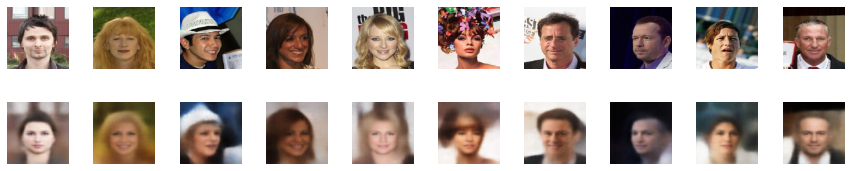

In [70]:
#Reconstructing the faces
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

_,_,z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

In [72]:
example_batch[0].shape

(10, 128, 128, 3)

20/20 [==============================] - 0s 16ms/step


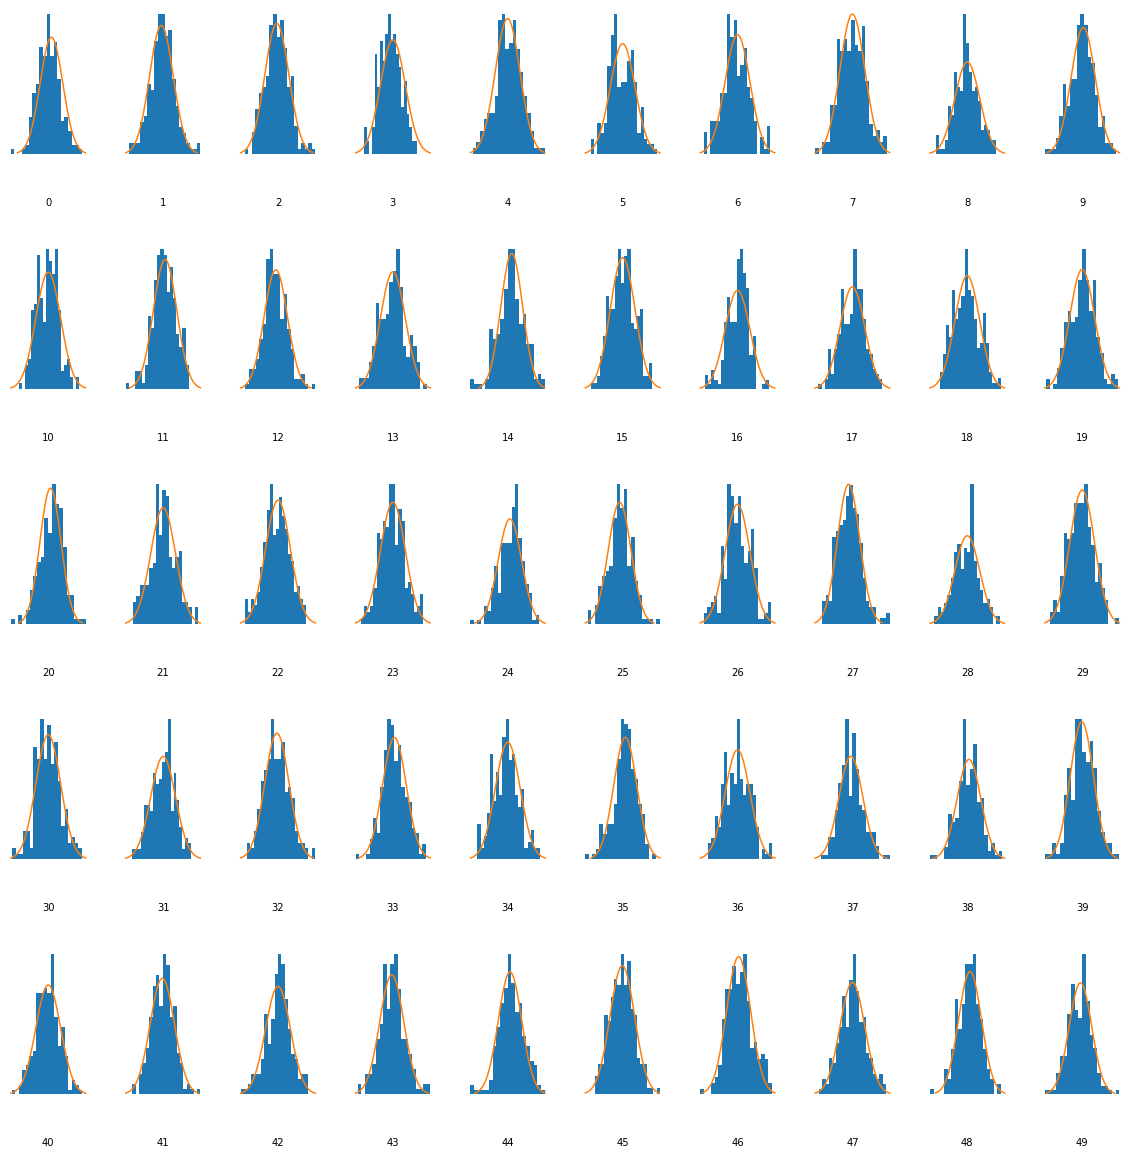

In [74]:
#Latent Space distrivution
from scipy.stats import norm

_,_,z_test = vae.encoder.predict(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

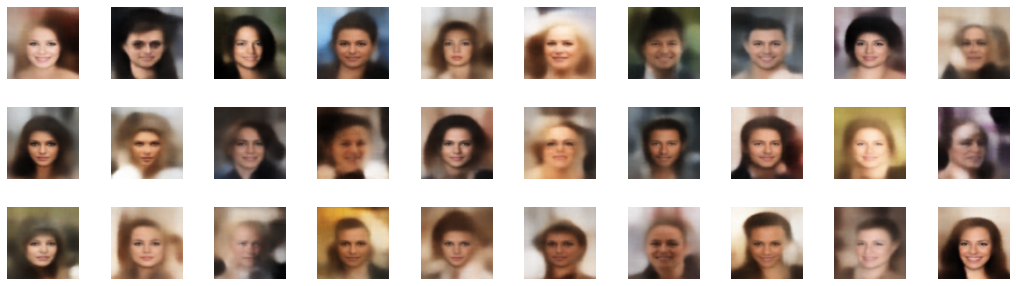

In [75]:
#Newly generated faces
n_to_show = 30

znew = np.random.normal(size = (n_to_show,vae.z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [76]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        _,_,z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   

In [77]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    _,_,z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()

In [78]:
BATCH_SIZE = 500
# attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
# mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
# smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
# lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
# young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
# male_vec = get_vector_from_label('Male', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
# blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 202592 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
37    : 2.884    : 0.724    : 3.121    : 3.121
75    : 1.606    : 0.441    : 2.652    : -0.469
99    : 0.831    : 0.284    : 2.355    : -0.297
125    : 0.666    : 0.188    : 2.244    : -0.111
151    : 0.462    : 0.144    : 2.156    : -0.088
196    : 0.609    : 0.128    : 2.016    : -0.14
231    : 0.402    : 0.094    : 1.933    : -0.083
257    : 0.309    : 0.082    : 1.896    : -0.037
285    : 0.264    : 0.07    : 1.894    : -0.002
319    : 0.284    : 0.067    : 1.858    : -0.036
352    : 0.243    : 0.056    : 1.828    : -0.031
378    : 0.206    : 0.059    : 1.807    : -0.02
402    : 0.186    : 0.055    : 1.798    : -0.009
430    : 0.18    : 0.048    : 1.801    : 0.003
467    : 0.184    : 0.043    : 1.788    : -0.013
508    : 0.183    : 0.042    : 1.763    : -0.025
542    : 0.164    : 0.04    : 1.758    : -0.005
571    : 0.131    : 0.037    : 1.756    : -0.002
602    : 0.137    

Eyeglasses Vector


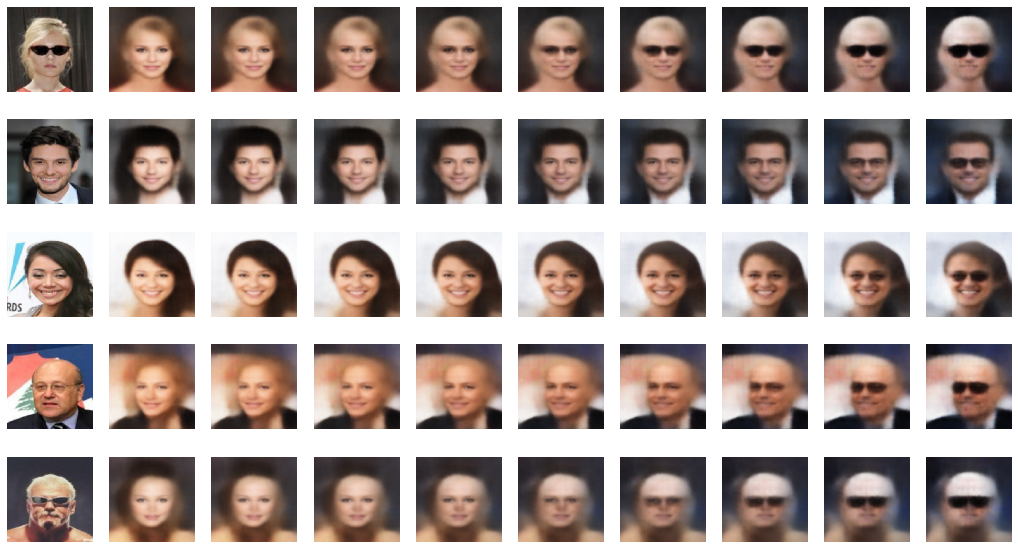

In [79]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

In [80]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    _,_,z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 validated image filenames.


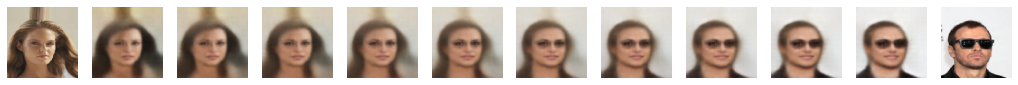

In [81]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


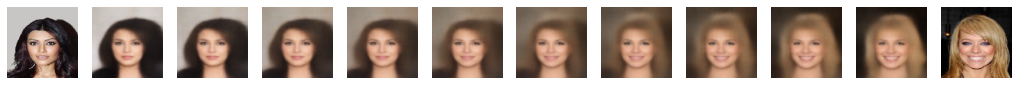

In [82]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


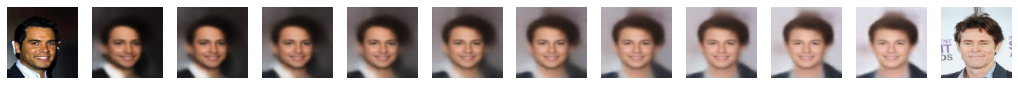

In [83]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)